# Отчет по лабораторной работе №7. Задача Коши и решение систем ДУ.
## Выполнил Руденко М.С., 432 группа, 9 вариант


## Постановка задачи

Рассмотрим численное решение уравнения 

$$
y'''-2y''+y'-2y=cos(x)\cdot e^{2x},\quad y(0)=1, y'(0)=0, y''(0)= 0\quad x\in[0,2]
$$

запишем его в виде системы ДУ 1-го порядка:

$$
\begin{cases}
y'=q=f_1(x,y,q,z)\\
y''=q'=z=f_2(x,y,q,z)\\
z'=f_3(x,y,q,z)=cos(x)\cdot e^{2x}+2z-q+2y
\end{cases}%,\qquad i=2,3,\ldots, n
$$

В программе используется векторный подход: массив переменных <code>Y=[y q z], y=Y[0], q=Y[1], z=Y[2]</code>, и система имеет вид

$$
\begin{cases}
Y[0]'=Y[1]\\
Y[1]'=Y[2]\\
Y[2]'=cos(x)\cdot e^{2x}+2Y[2]-Y[1]+2Y[0]
\end{cases}
$$

Здесь сопоставляется вектор производных и вектор правых частей

$$
Y'=f(x,Y),\; \text{где}\;f(x,Y)=
\begin{bmatrix}
Y[1]\\
Y[2]\\
cos(x)\cdot e^{2x}+2Y[2]-Y[1]+2Y[0]
\end{bmatrix}
$$

## Метод Мерсона

Одной из проблем, связанных с реализацией методов Рунге-Кутты, является выбор шага для достижения заданной точности. Решается она либо применением правила Рунге, что значительно увеличивает объем вычислений, либо путем использования специальных формул для вычисления погрешности, содержащих только величины ${k_r}$, (метод Мерсона). Например, для явного пятикратного метода
$$
k_1=\frac{1}{3}f(x_n,y_n) \\
k_2=\frac{1}{3}f(x_n+\frac{h}{3},y_n+hk_1) \\
k_3=\frac{1}{3}f(x_n+\frac{h}{3},y_n+\frac{h}{2}k_1+\frac{h}{2}k_2) \\
k_4=\frac{1}{3}f(x_n+\frac{h}{2},y_n+\frac{3}{8}hk_1+\frac{9}{8}hk_3) \\
k_5=\frac{1}{3}f(x_n+h,y_n+\frac{3}{2}hk_1-\frac{9}{2}hk_3+6hk_4) \\
$$
Можно показать, что в векторном виде итерационный процесс решения методом Мерсона будет записываться в виде

$$
Y^{n+1}=Y^n+\frac{h}{2}(k_1+4k_4+k_5)
$$

Где все функции (вектора, матрицы) берутся в точке $Y^n, x^n$.

Импорт библиотек

In [ ]:
from sympy import Symbol,diff,exp,cos,sin,Matrix,var,symbols
import sympy as sym
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy import interpolate
from numpy.linalg import norm
import math as m

Зададим условия расчетов:

In [ ]:
n=3 # количество переменных
y00=np.array([1.,0.,0.]) # начальные условия y(0)=1,y'(0)=0
Tn0,tmax0=0,2 # временной интервал
h=0.1 # начальный шаг
eps=0.01 # точность

Наша система

In [ ]:
def f1(x,y0):   # y'(x)
    yo = y0[:]
    return yo[1]

def f2(x,y0):   # y"(x)
    yo = y0[:]
    return yo[2]

def f3(x,y0): # y''' выраженная
    yo = y0[:]
    return m.cos(x)*m.exp(2*x) + 2*yo[2] - yo[1] + 2*yo[0]

Зададим массив времени(наш x) и массив координат решения:

In [ ]:
Time=np.array([])
Y = np.empty((0,n),np.float32)

Итерационный процесс:

In [ ]:
N=0
while True:
    h=h/2
    yn=np.array([1.,0.,0.])
    Tn=Tn0
    tmax=tmax0  

    N+=1

    OldTime=Time
    OldY=Y

    Time=np.array([])
    Y = np.empty((0,n),np.float32)
    k1,k2,k3 = np.zeros(5), np.zeros(5), np.zeros(5)
    while Tn<=tmax:
        y0=yn
        Time=np.append(Time,Tn)
        Tn=Tn+h
        x = Tn
        Y=np.append(Y,[y0],axis=0)

        k1[0] = (1/3)*f1(x,y0)
        k2[0] = (1/3)*f2(x,y0)
        k3[0] = (1/3)*f3(x,y0)
        k1[1] = (1/3)*f1(x+(h/3),[y0[0]+h*k1[0],y0[1]+h*k2[0],y0[2]+h*k3[0]])
        k2[1] = (1/3)*f2(x+(h/3),[y0[0]+h*k1[0],y0[1]+h*k2[0],y0[2]+h*k3[0]])
        k3[1] = (1/3)*f3(x+(h/3),[y0[0]+h*k1[0],y0[1]+h*k2[0],y0[2]+h*k3[0]])
        k1[2] = (1/3)*f1(x+(h/3),[y0[0]+(h/2)*k1[0]+(h/2)*k1[1],
                                  y0[1]+(h/2)*k2[0]+(h/2)*k2[1],
                                  y0[2]+(h/2)*k3[0]+(h/2)*k3[1]])
        k2[2] = (1/3)*f2(x+(h/3),[y0[0]+(h/2)*k1[0]+(h/2)*k1[1],
                                  y0[1]+(h/2)*k2[0]+(h/2)*k2[1],
                                  y0[2]+(h/2)*k3[0]+(h/2)*k3[1]])
        k3[2] = (1/3)*f3(x+(h/3),[y0[0]+(h/2)*k1[0]+(h/2)*k1[1],
                                  y0[1]+(h/2)*k2[0]+(h/2)*k2[1],
                                  y0[2]+(h/2)*k3[0]+(h/2)*k3[1]])
        k1[3] = (1/3)*f1(x+(h/2),[y0[0]+(3/8)*h*k1[0]+(9/8)*h*k1[2],
                                  y0[1]+(3/8)*h*k2[0]+(9/8)*h*k2[2],
                                  y0[2]+(3/8)*h*k3[0]+(9/8)*h*k3[2]])
        k2[3] = (1/3)*f2(x+(h/2),[y0[0]+(3/8)*h*k1[0]+(9/8)*h*k1[2],
                                  y0[1]+(3/8)*h*k2[0]+(9/8)*h*k2[2],
                                  y0[2]+(3/8)*h*k3[0]+(9/8)*h*k3[2]])
        k3[3] = (1/3)*f3(x+(h/2),[y0[0]+(3/8)*h*k1[0]+(9/8)*h*k1[2],
                                  y0[1]+(3/8)*h*k2[0]+(9/8)*h*k2[2],
                                  y0[2]+(3/8)*h*k3[0]+(9/8)*h*k3[2]])
        k1[4] = (1/3)*f1(x+h,[y0[0]+(3/2)*h*k1[0]-(9/2)*h*k1[2]+6*h*k1[3],
                                  y0[1]+(3/2)*h*k2[0]-(9/2)*h*k2[2]+6*h*k2[3],
                                  y0[2]+(3/2)*h*k3[0]-(9/2)*h*k3[2]+6*h*k3[3]])
        k2[4] = (1/3)*f2(x+h,[y0[0]+(3/2)*h*k1[0]-(9/2)*h*k1[2]+6*h*k1[3],
                                  y0[1]+(3/2)*h*k2[0]-(9/2)*h*k2[2]+6*h*k2[3],
                                  y0[2]+(3/2)*h*k3[0]-(9/2)*h*k3[2]+6*h*k3[3]])
        k3[4] = (1/3)*f3(x+h,[y0[0]+(3/2)*h*k1[0]-(9/2)*h*k1[2]+6*h*k1[3],
                                  y0[1]+(3/2)*h*k2[0]-(9/2)*h*k2[2]+6*h*k2[3],
                                  y0[2]+(3/2)*h*k3[0]-(9/2)*h*k3[2]+6*h*k3[3]])
        yn[0] = y0[0] + (h/2)*(k1[0]+4*k1[3]+k1[4])
        yn[1] = y0[1] + (h/2)*(k2[0]+4*k2[3]+k2[4])
        yn[2] = y0[2] + (h/2)*(k3[0]+4*k3[3]+k3[4])
    print('итерация',N,len(Y))
    if N>=3:
        YY=Y
        YO=OldY
        if len(YY)%2!=0:
            YY=YY[:-1]
        if len(YO)%2!=0:
            YO=YO[:-1]
        YY=np.array(YY,dtype=np.float32)
        YO=np.array(YO,dtype=np.float32)
        #delta = norm((YY[0::2]-YO))
        delta=np.max(norm((YY[0::2]-YO),axis=0))
        print('погрешность',delta)
        if N>11:
            break
        if delta<eps:
            break

итерация 1 40
итерация 2 81
итерация 3 161
погрешность 1.2318332
итерация 4 320
погрешность 0.89151675
итерация 5 640
погрешность 0.6376467
итерация 6 1281
погрешность 0.45344013
итерация 7 2561
погрешность 0.3215371
итерация 8 5120
погрешность 0.2276838
итерация 9 10240
погрешность 0.16110604
итерация 10 20481
погрешность 0.11396261
итерация 11 40961
погрешность 0.08059606
итерация 12 81920
погрешность 0.05699245


Так же решим встроенным решателем:

In [ ]:
def model(t,z):
	y1, y2, y3=z[0], z[1], z[2]
	return [y2,y3,m.cos(t)*m.exp(2*t) + 2*y3 - y2 + 2*y1]

solve = solve_ivp(model,[Tn0,tmax0],y00,method='RK45',min_step=0.001,max_step=0.001)

Time2=solve.t
Z=solve.y

Z1,Z2,Z3=Z
Y1,Y2,Y3=Y.T

График решения

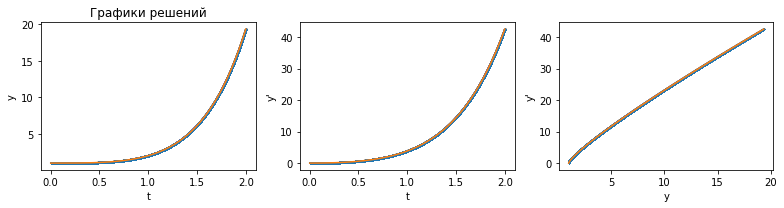

In [ ]:
f, (ax1, ax2,ax3) = plt.subplots(1,3, gridspec_kw = {'width_ratios':[3, 3,3]})
f.set_size_inches(11,3)

ax1.set_title('Графики решений')
ax1.plot(Time,Y1,'*', markersize=1)
ax1.plot(Time2,Z1)
ax1.set_ylabel("y")
ax1.set_xlabel("t")

ax2.plot(Time,Y2,'*', markersize=1)
ax2.plot(Time2,Z2)
ax2.set_ylabel("y'")
ax2.set_xlabel("t")

ax3.plot(Y1,Y2,'*', markersize=1)
ax3.plot(Z1,Z2)
ax3.set_xlabel("y")
ax3.set_ylabel("y'")

f.tight_layout()
plt.show()

Чтобы не возиться с вычитанием массивов разной длины, можно решения разными способами  простейшим способом интерполировать на нужном отрезке (соединяя точки) и построить разность интерполирующих функций на одном и том же разбиении:

In [41]:
def real_func(x): # точное решение y(x)
  return (1/40)*(8*exp(2*x)+(5*exp(2*x)-11)*sin(x)+(37-5*exp(2*x))*cos(x))
x = np.linspace(np.min(Time), np.max(Time),1000)
y_real = [real_func(x[i]) for i in range(len(x))]
f = interpolate.interp1d(x, y_real,axis=0, fill_value="extrapolate")
y_real1f = f(x)

def real_funcY1(x): # точное решение y'(x)
  return 2*exp(2*x)/5 + exp(2*x)*(sin(x)-cos(x))/4 + (cos(x)*(5*exp(2*x)-11)-sin(x)*(37-5*exp(2*x)))/40
y_real = [real_funcY1(x[i]) for i in range(len(x))]
f = interpolate.interp1d(x, y_real,axis=0, fill_value="extrapolate")
y_real1fY1 = f(x)

Выше функция точного решения и ее интерполяция

In [ ]:
x = np.linspace(np.min(Time), np.max(Time),1000)
f = interpolate.interp1d(Time, Y1,axis=0, fill_value="extrapolate")
Y1f=f(x)
f = interpolate.interp1d(Time2, Z1,axis=0, fill_value="extrapolate")
Z1f=f(x)

x = np.linspace(np.min(Time), np.max(Time),1000)
f = interpolate.interp1d(Time, Y2,axis=0, fill_value="extrapolate")
Y2f=f(x)
f = interpolate.interp1d(Time2, Z2,axis=0, fill_value="extrapolate")
Z2f=f(x)

Разностные графики:

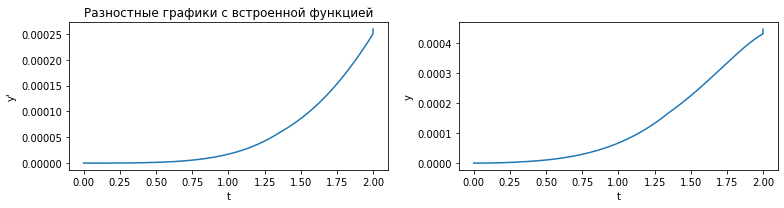

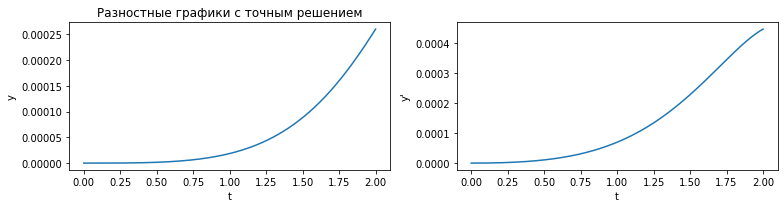

In [43]:
f, (plt1, plt2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1,1]})
f.set_size_inches(11,3)
plt1.set_title('Разностные графики с встроенной функцией')
plt1.plot(x,Y1f-Z1f)
plt1.set_ylabel("y'")
plt1.set_xlabel("t")

plt2.plot(x,Y2f-Z2f)
plt2.set_ylabel("y")
plt2.set_xlabel("t")

f.tight_layout()
plt.show()

f, (plt1, plt2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':[1,1]})
f.set_size_inches(11,3)
plt1.set_title('Разностные графики с точным решением')
plt1.plot(x,Y1f-y_real1f)
plt1.set_ylabel("y")
plt1.set_xlabel("t")

plt2.plot(x,Y2f-y_real1fY1)
plt2.set_ylabel("y'")
plt2.set_xlabel("t")

f.tight_layout()
plt.show()

## Выводы

Выбранной схемой решения (метод Мерсона) получено решение на отрезке (0,2) за 12 итераций по погрешности = 0.05 от начального шага 0.1 с погрешностью 0.01 (итерируется от сетки с ~40 узлов до ~81920 узлов). Заданную погрешность между собственными решениями можно дожидаться часами, но т.к. разностные графики хорошие можно оставить и в таком виде.

Построены необходимые графики решения от времени, сопоставленные графикам полученным встроенной функцией и точного решения, а также их разностные графики от времени.